<a href="https://colab.research.google.com/github/yashwardhan-gautam/Grid2.0/blob/master/VoiceFilter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Basic necessary definitions

#### Hyper Parameters

In [ ]:
class HyperParams:
  n_fft= 1200
  num_freq= 601 # n_fft//2 + 1
  sample_rate= 16000
  hop_length= 160
  win_length= 400
  min_level_db= -100.0
  ref_level_db= 20.0
  preemphasis= 0.97
  power= 0.30
  embedder_window= 80
  data_audio_len= 3.0
  embedder_num_mels= 40
  embedder_lstm_hidden = 768
  embedder_emb_dim = 256
  embedder_lstm_layers = 3
  embedder_window = 80
  embedder_stride = 40
  model_lstm_dim = 400
  model_fc1_dim = 600
  model_fc2_dim = 601 # num_freq

#### Audio related helper functions

In [ ]:
import librosa
import numpy as np  

In [ ]:
class Audio:
  def __init__(self,hyper_params):
    self.hyper_params = hyper_params
    self.mel_basis_matrix = librosa.filters.mel(sr=hyper_params.sample_rate,
                                             n_fft=hyper_params.n_fft,
                                             n_mels=hyper_params.embedder_num_mels);

  def get_mel_spec(self,wave):
    spec = librosa.core.stft(y=wave, n_fft=self.hyper_params.n_fft,
                              hop_length=self.hyper_params.hop_length,
                              win_length=self.hyper_params.win_length,
                              window='hann')
    power_spec = np.abs(spec) ** 2
    mel_spec = np.log10(np.dot(self.mel_basis_matrix,power_spec)+1e-6)
    return mel_spec  
  def wave2spec(self,wave): 
    spec = librosa.core.stft(y=wave, n_fft=self.hyper_params.n_fft,
                            hop_length=self.hyper_params.hop_length,
                            win_length=self.hyper_params.win_length)
    phase = np.angle(spec)
    spec_db = self.amp2db(np.abs(spec))
    spec_db_norm = self.normalize(spec_db)
    spec_db_norm = spec_db_norm.T   # Taking transpose here
    phase = phase.T # Taking transpose here
    return spec_db_norm, phase
  def spec2wave(self,spec_db_norm,phase):
    spec_db_norm, phase = spec_db_norm.T, phase.T
    spec_db = self.denormalize(spec_db_norm)
    spec_amp = self.db2amp(spec_db)
    spec = spec_amp * np.exp(1j*phase)
    wave = librosa.core.istft(spec,
                             hop_length=self.hyper_params.hop_length,
                             win_length=self.hyper_params.win_length)
    return wave
  def amp2db(self,mat):
    return 20.0 * np.log10(np.maximum(1e-5,mat)) - self.hyper_params.ref_level_db
  def db2amp(self,mat):
    return np.power(10.0, (mat+self.hyper_params.ref_level_db)*0.05)
  def normalize(self,mat):
    return np.clip((mat-self.hyper_params.min_level_db)/-self.hyper_params.min_level_db, 0.0 , 1.0)
  def denormalize(self, mat):
    return np.clip(mat,0.0,1.0)*(-self.hyper_params.min_level_db)+self.hyper_params.min_level_db

In [ ]:
hyper_params = HyperParams()
audio = Audio(hyper_params)

#### Define paths and create folders

In [ ]:
import os

In [ ]:
# dataset_path = os.path.join('drive','MyDrive','CS753 ASR Project','LibriSpeech Dataset');
!mkdir './LibriSpeech Dataset'
dataset_path = os.path.join('./LibriSpeech Dataset');
path = {}
path['dev'] = os.path.join(dataset_path,'LibriSpeech Dev Dataset')
path['test'] = os.path.join(dataset_path,'LibriSpeech Test Dataset')
path['train'] = os.path.join(dataset_path ,'LibriSpeech Train Dataset')

mkdir: cannot create directory ‘./LibriSpeech Dataset’: File exists


In [ ]:
# create directories to store dataset
for dataset in ('dev','test','train'):
  os.makedirs(os.path.join(path[dataset],'input_spec'),exist_ok=True)
  os.makedirs(os.path.join(path[dataset],'output_spec'),exist_ok=True)
  os.makedirs(os.path.join(path[dataset],'input_phase'),exist_ok=True)
  os.makedirs(os.path.join(path[dataset],'output_phase'),exist_ok=True)
  os.makedirs(os.path.join(path[dataset],'dvec'),exist_ok=True)
print('Directories created')

Directories created


In [ ]:
# create 8 separate directories for training dataset to avoid issues with gdrive
def create_folders(i):
  os.makedirs(os.path.join(path['train'],'input_spec_'+i),exist_ok=True)
  os.makedirs(os.path.join(path['train'],'output_spec_'+i),exist_ok=True)
  os.makedirs(os.path.join(path['train'],'input_phase_'+i),exist_ok=True)
  os.makedirs(os.path.join(path['train'],'output_phase_'+i),exist_ok=True)
  os.makedirs(os.path.join(path['train'],'dvec_'+i),exist_ok=True)

for i in range(8):
  create_folders(str(i))
print('Directories created')

### Unzip LibriSpeech dataset ( Execute just once )
ALREADY DONE IN DATA PREPARATION. DO NOT REPEAT.

ALSO, USE LINUX COMMANDS TO FIRST EXTRACT DATASETS IN VM, AND THEN MOVE TO DRIVE INSTEAD OF USING SHUTIL TO DIRECTLY EXTRACT IN DRIVE.

In [ ]:
# import shutil

In [ ]:
# shutil.unpack_archive(dataset_path+'/train-clean-100.tar.gz',dataset_path)
# Rename the extracted folder LibriSpeech to LibriSpeech Train Dataset

In [ ]:
# shutil.unpack_archive(dataset_path+'/dev-clean.tar.gz',dataset_path)
# Rename the extracted folder LibriSpeech to LibriSpeech Dev Dataset

In [ ]:
# shutil.unpack_archive(dataset_path+'/test-clean.tar.gz',dataset_path)
# Rename the extracted folder LibriSpeech to LibriSpeech Test Dataset

In [ ]:
# !rm -r "drive/MyDrive/LibriSpeech Dataset/"

In [ ]:
# !mkdir "drive/MyDrive/LibriSpeech Dataset/"
# !mkdir "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Test Dataset"
# !mkdir "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Dev Dataset"
# !mkdir "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset"

# %ls "drive/MyDrive/LibriSpeech Dataset/"

# %cd "LibriSpeech Dataset/"

# !wget https://www.openslr.org/resources/12/test-clean.tar.gz
# !time cp "test-clean.tar.gz" "../drive/MyDrive/LibriSpeech Dataset/"
# !tar -xf "test-clean.tar.gz"
# !mv LibriSpeech "LibriSpeech Test Dataset"

# !wget https://www.openslr.org/resources/12/dev-clean.tar.gz
# !time cp "dev-clean.tar.gz" "../drive/MyDrive/LibriSpeech Dataset/"
# !tar -xf "dev-clean.tar.gz"
# !mv LibriSpeech "LibriSpeech Dev Dataset"

# !wget https://www.openslr.org/resources/12/train-clean-100.tar.gz
# !time cp "train-clean-100.tar.gz" "../drive/MyDrive/LibriSpeech Dataset/" # approx 4 mins
# !tar -xf "train-clean-100.tar.gz"
# !mv LibriSpeech "LibriSpeech Train Dataset"

# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1YFmhmUok-W76JkrfA0fzQt3c-ZsfiwfL' -O embedder.pt
# !cp embedder.pt "../drive/MyDrive/LibriSpeech Dataset/"

# %cd ..

In [ ]:
%cd "LibriSpeech Dataset/"
# !time cp "../drive/MyDrive/LibriSpeech Dataset/train-clean-100.tar.gz" .
# !time tar -xf train-clean-100.tar.gz
# !mv LibriSpeech "LibriSpeech Train Dataset"
# !rm train-clean-100.tar.gz

!time cp "../drive/MyDrive/LibriSpeech Dataset/test-clean.tar.gz" .
!tar -xf "test-clean.tar.gz"
!mv LibriSpeech "LibriSpeech Test Dataset"
!rm test-clean.tar.gz

!time cp "../drive/MyDrive/LibriSpeech Dataset/dev-clean.tar.gz" .
!tar -xf "dev-clean.tar.gz"
!mv LibriSpeech "LibriSpeech Dev Dataset"
!rm dev-clean.tar.gz

!time cp "../drive/MyDrive/LibriSpeech Dataset/embedder.pt" .
%cd ..

/content/LibriSpeech Dataset

real	0m4.711s
user	0m0.008s
sys	0m0.441s

real	0m4.749s
user	0m0.003s
sys	0m0.412s

real	0m1.787s
user	0m0.001s
sys	0m0.064s
/content


In [ ]:
## copy test dataset
%cd "LibriSpeech Dataset/LibriSpeech Test Dataset/"

!time cp "../../drive/MyDrive/LibriSpeech Dataset/LibriSpeech Test Dataset/dvec.tar" .
!time tar -xf dvec.tar
!mv "LibriSpeech Dataset/LibriSpeech Test Dataset/dvec/" .
!rm -r "LibriSpeech Dataset/LibriSpeech Test Dataset/"
!rm dvec.tar
print("dvec done")

!time cp "../../drive/MyDrive/LibriSpeech Dataset/LibriSpeech Test Dataset/input_phase.tar" .
!time tar -xf input_phase.tar
!mv "LibriSpeech Dataset/LibriSpeech Test Dataset/input_phase/" .
!rm -r "LibriSpeech Dataset/LibriSpeech Test Dataset/"
!rm input_phase.tar
print("input_phase done")

!time cp "../../drive/MyDrive/LibriSpeech Dataset/LibriSpeech Test Dataset/output_phase.tar" .
!time tar -xf output_phase.tar
!mv "LibriSpeech Dataset/LibriSpeech Test Dataset/output_phase/" .
!rm -r "LibriSpeech Dataset/LibriSpeech Test Dataset/"
!rm output_phase.tar
print("output_phase done")

!time cp "../../drive/MyDrive/LibriSpeech Dataset/LibriSpeech Test Dataset/input_spec.tar" .
!time tar -xf input_spec.tar
!mv "LibriSpeech Dataset/LibriSpeech Test Dataset/input_spec/" .
!rm -r "LibriSpeech Dataset/LibriSpeech Test Dataset/"
!rm input_spec.tar
print("input_spec done")

!time cp "../../drive/MyDrive/LibriSpeech Dataset/LibriSpeech Test Dataset/output_spec.tar" .
!time tar -xf output_spec.tar
!mv "LibriSpeech Dataset/LibriSpeech Test Dataset/output_spec/" .
!rm -r "LibriSpeech Dataset/LibriSpeech Test Dataset/"
!rm output_spec.tar
print("output_spec done")

!time cp "../../drive/MyDrive/LibriSpeech Dataset/LibriSpeech Test Dataset/test_speeches.data" test_speeches.data
!time cp "../../drive/MyDrive/LibriSpeech Dataset/LibriSpeech Test Dataset/data_frame.csv" data_frame.csv
print("ALL done")

%cd ../..

%ls -l "LibriSpeech Dataset/LibriSpeech Test Dataset/dvec/" | wc -l
%ls -l "LibriSpeech Dataset/LibriSpeech Test Dataset/input_phase/" | wc -l
%ls -l "LibriSpeech Dataset/LibriSpeech Test Dataset/output_phase/" | wc -l
%ls -l "LibriSpeech Dataset/LibriSpeech Test Dataset/input_spec/" | wc -l
%ls -l "LibriSpeech Dataset/LibriSpeech Test Dataset/output_spec/" | wc -l
!wc -l "LibriSpeech Dataset/LibriSpeech Test Dataset/test_speeches.data"
!wc -l "LibriSpeech Dataset/LibriSpeech Test Dataset/data_frame.csv"

/content/LibriSpeech Dataset/LibriSpeech Test Dataset

real	0m0.934s
user	0m0.001s
sys	0m0.005s

real	0m0.039s
user	0m0.002s
sys	0m0.036s
dvec done

real	0m34.479s
user	0m0.003s
sys	0m0.811s

real	0m19.347s
user	0m0.042s
sys	0m0.754s
input_phase done

real	0m30.991s
user	0m0.010s
sys	0m0.834s

real	0m16.189s
user	0m0.026s
sys	0m0.821s
output_phase done

real	0m32.112s
user	0m0.011s
sys	0m0.825s

real	0m17.105s
user	0m0.019s
sys	0m0.770s
input_spec done

real	0m34.344s
user	0m0.008s
sys	0m0.836s

real	0m15.537s
user	0m0.022s
sys	0m0.860s
output_spec done

real	0m5.917s
user	0m0.000s
sys	0m0.004s

real	0m0.666s
user	0m0.002s
sys	0m0.002s
ALL done
/content
950
950
950
950
950
112 LibriSpeech Dataset/LibriSpeech Test Dataset/test_speeches.data
950 LibriSpeech Dataset/LibriSpeech Test Dataset/data_frame.csv


In [ ]:
## copy dev dataset
%cd "LibriSpeech Dataset/LibriSpeech Dev Dataset/"

!time cp "../../drive/MyDrive/LibriSpeech Dataset/LibriSpeech Dev Dataset/dvec.tar" .
!time tar -xf dvec.tar
!mv "LibriSpeech Dataset/LibriSpeech Dev Dataset/dvec/" .
!rm -r "LibriSpeech Dataset/LibriSpeech Dev Dataset/"
!rm dvec.tar
print("dvec done")

!time cp "../../drive/MyDrive/LibriSpeech Dataset/LibriSpeech Dev Dataset/input_phase.tar" .
!time tar -xf input_phase.tar
!mv "LibriSpeech Dataset/LibriSpeech Dev Dataset/input_phase/" .
!rm -r "LibriSpeech Dataset/LibriSpeech Dev Dataset/"
!rm input_phase.tar
print("input_phase done")

!time cp "../../drive/MyDrive/LibriSpeech Dataset/LibriSpeech Dev Dataset/output_phase.tar" .
!time tar -xf output_phase.tar
!mv "LibriSpeech Dataset/LibriSpeech Dev Dataset/output_phase/" .
!rm -r "LibriSpeech Dataset/LibriSpeech Dev Dataset/"
!rm output_phase.tar
print("output_phase done")

!time cp "../../drive/MyDrive/LibriSpeech Dataset/LibriSpeech Dev Dataset/input_spec.tar" .
!time tar -xf input_spec.tar
!mv "LibriSpeech Dataset/LibriSpeech Dev Dataset/input_spec/" .
!rm -r "LibriSpeech Dataset/LibriSpeech Dev Dataset/"
!rm input_spec.tar
print("input_spec done")

!time cp "../../drive/MyDrive/LibriSpeech Dataset/LibriSpeech Dev Dataset/output_spec.tar" .
!time tar -xf output_spec.tar
!mv "LibriSpeech Dataset/LibriSpeech Dev Dataset/output_spec/" .
!rm -r "LibriSpeech Dataset/LibriSpeech Dev Dataset/"
!rm output_spec.tar
print("output_spec done")

!time cp "../../drive/MyDrive/LibriSpeech Dataset/LibriSpeech Dev Dataset/dev_speeches.data" dev_speeches.data
!time cp "../../drive/MyDrive/LibriSpeech Dataset/LibriSpeech Dev Dataset/data_frame.csv" data_frame.csv
print("ALL done")

%cd ../..

%ls -l "LibriSpeech Dataset/LibriSpeech Dev Dataset/dvec/" | wc -l
%ls -l "LibriSpeech Dataset/LibriSpeech Dev Dataset/input_phase/" | wc -l
%ls -l "LibriSpeech Dataset/LibriSpeech Dev Dataset/output_phase/" | wc -l
%ls -l "LibriSpeech Dataset/LibriSpeech Dev Dataset/input_spec/" | wc -l
%ls -l "LibriSpeech Dataset/LibriSpeech Dev Dataset/output_spec/" | wc -l
!wc -l "LibriSpeech Dataset/LibriSpeech Dev Dataset/dev_speeches.data"
!wc -l "LibriSpeech Dataset/LibriSpeech Dev Dataset/data_frame.csv"

/content/LibriSpeech Dataset/LibriSpeech Dev Dataset

real	0m0.870s
user	0m0.001s
sys	0m0.005s

real	0m0.034s
user	0m0.003s
sys	0m0.031s
dvec done

real	0m25.613s
user	0m0.004s
sys	0m0.810s

real	0m17.573s
user	0m0.033s
sys	0m0.756s
input_phase done

real	0m29.299s
user	0m0.010s
sys	0m0.823s

real	0m17.452s
user	0m0.013s
sys	0m0.765s
output_phase done

real	0m33.164s
user	0m0.005s
sys	0m0.801s

real	0m16.914s
user	0m0.022s
sys	0m0.776s
input_spec done

real	0m33.654s
user	0m0.010s
sys	0m0.805s

real	0m16.645s
user	0m0.020s
sys	0m0.836s
output_spec done

real	0m1.138s
user	0m0.001s
sys	0m0.003s

real	0m0.494s
user	0m0.002s
sys	0m0.002s
ALL done
/content
921
921
921
921
921
195 LibriSpeech Dataset/LibriSpeech Dev Dataset/dev_speeches.data
921 LibriSpeech Dataset/LibriSpeech Dev Dataset/data_frame.csv


### Create and store speech collection

In [ ]:
import glob
import pickle

In [ ]:
# #### Run this cell only the first time ####
# dev_base_path = os.path.join(path['dev'],'LibriSpeech','dev-clean')
# test_base_path = os.path.join(path['test'],'LibriSpeech','test-clean')
# train_base_path = os.path.join(path['train'],'LibriSpeech','train-clean-100')

In [ ]:
# #### Run this cell only the first time ####
# dev_spks = os.listdir(dev_base_path)
# # list of all speaker folders
# dev_speeches = [glob.glob(os.path.join(dev_base_path,spk,'*','*.flac'),recursive=True) for spk in dev_spks]
# dev_speeches = [speeches for speeches in dev_speeches if len(speeches)>=2]
# # list of lists containing speeches of a speaker
# test_spks = os.listdir(test_base_path)
# # list of all speaker folders
# test_speeches = [glob.glob(os.path.join(test_base_path,spk,'*','*.flac'),recursive=True) for spk in test_spks]
# test_speeches = [speeches for speeches in test_speeches if len(speeches)>=2]
# # list of lists containing speeches of a speaker
# train_spks = os.listdir(train_base_path)
# # list of all speaker folders
# train_speeches = [glob.glob(os.path.join(train_base_path,spk,'*','*.flac'),recursive=True) for spk in train_spks]
# train_speeches = [speeches for speeches in train_speeches if len(speeches)>=2]
# # list of lists containing speeches of a speaker

In [ ]:
##### Run this cell only the first time #####
# with open(os.path.join(path['dev'],'dev_speeches.data'),'wb') as f:
#   pickle.dump(dev_speeches,f)
# with open(os.path.join(path['test'],'test_speeches.data'),'wb') as f:
#   pickle.dump(test_speeches,f)
# with open(os.path.join(path['train'],'train_speeches.data'),'wb') as f:
#   pickle.dump(train_speeches,f)

In [ ]:
with open(os.path.join(path['dev'],'dev_speeches.data'),'rb') as f:
  dev_speeches = pickle.load(f)
with open(os.path.join(path['test'],'test_speeches.data'),'rb') as f:
  test_speeches = pickle.load(f)
# with open(os.path.join(path['train'],'train_speeches.data'),'rb') as f:
#   train_speeches = pickle.load(f)

### Use pre trained model to obtain Embedding

In [ ]:
import torch
import torch.nn as nn

class LinearNorm(nn.Module):
    def __init__(self, hp):
        super(LinearNorm, self).__init__()
        self.linear_layer = nn.Linear(hp.embedder_lstm_hidden, hp.embedder_emb_dim)

    def forward(self, x):
        return self.linear_layer(x)


class SpeechEmbedder(nn.Module):
    def __init__(self, hp):
        super(SpeechEmbedder, self).__init__()
        self.lstm = nn.LSTM(hp.embedder_num_mels,
                            hp.embedder_lstm_hidden,
                            num_layers=hp.embedder_lstm_layers,
                            batch_first=True)
        self.proj = LinearNorm(hp)
        self.hp = hp

    def forward(self, mel):
        # (num_mels, T)
        mels = mel.unfold(1, self.hp.embedder_window, self.hp.embedder_stride) # (num_mels, T', window)
        mels = mels.permute(1, 2, 0) # (T', window, num_mels)
        x, _ = self.lstm(mels) # (T', window, lstm_hidden)
        x = x[:, -1, :] # (T', lstm_hidden), use last frame only
        x = self.proj(x) # (T', emb_dim)
        x = x / torch.norm(x, p=2, dim=1, keepdim=True) # (T', emb_dim)
        x = x.sum(0) / x.size(0) # (emb_dim), average pooling over time frames
        return x

In [ ]:
# Embedder downloaded from https://drive.google.com/file/d/1YFmhmUok-W76JkrfA0fzQt3c-ZsfiwfL/view (https://github.com/mindslab-ai/voicefilter)
embedder_path = os.path.join(dataset_path,"embedder.pt")
embedder_pt = torch.load(embedder_path,map_location=torch.device('cpu'))
embedder = SpeechEmbedder(hyper_params)
embedder.load_state_dict(embedder_pt)
embedder.eval()

SpeechEmbedder(
  (lstm): LSTM(40, 768, num_layers=3, batch_first=True)
  (proj): LinearNorm(
    (linear_layer): Linear(in_features=768, out_features=256, bias=True)
  )
)

### Prepare dataset

In [ ]:
import random
import pandas as pd

In [ ]:
# returns dvec for the input wave using pre trained embedder model
def get_dvector(wave):
  mel_spec = audio.get_mel_spec(wave)
  dvec = embedder(torch.from_numpy(mel_spec).float())
  dvec = dvec.detach().numpy()
  return dvec

In [ ]:
# pre process waves and store spectrogram, phase and dvector in their respective folders
def create_example(target_dir, hyper_params, idx, ref_speech, pri_speech, sec_speech):
  sample_rate = hyper_params.sample_rate
  ref_wave, _ = librosa.load(ref_speech,sr=sample_rate) #load the audio file
  pri_wave, _ = librosa.load(pri_speech, sr = sample_rate)
  sec_wave,_ = librosa.load(sec_speech, sr = sample_rate)
  assert len(ref_wave.shape)==len(pri_wave.shape)==len(sec_wave.shape)==1,\
  'wave files must be mono and not stereo'
  ref_wave,_ = librosa.effects.trim(ref_wave, top_db = 20) # clip silent portion on both ends
  pri_wave,_ = librosa.effects.trim(pri_wave, top_db = 20)
  sec_wave,_ = librosa.effects.trim(sec_wave, top_db = 20)
  
  if ref_wave.shape[0] < 1.1 * hyper_params.embedder_window * hyper_params.hop_length :
    return
  length_wave = int(sample_rate * hyper_params.data_audio_len)
  if pri_wave.shape[0]<length_wave or sec_wave.shape[0]<length_wave:
    return
  pri_wave, sec_wave = pri_wave[:length_wave], sec_wave[:length_wave] # clip wave to fixed length
  mix_wave = pri_wave + sec_wave
  norm = np.max(np.abs(mix_wave)) * 1.1
  pri_wave, mix_wave = pri_wave/norm , mix_wave/norm  # normalize wave by 1.1*max(absolute amplitude)
  pri_spec, pri_phase = audio.wave2spec(pri_wave)  # convert wave to spec
  mix_spec, mix_phase = audio.wave2spec(mix_wave)
  dvec = get_dvector(ref_wave)

  # paths for storing data
  pri_spec_path = os.path.join(target_dir,'output_spec','%06d.npy'%idx)
  pri_phase_path = os.path.join(target_dir,'output_phase','%06d.npy'%idx)
  mix_spec_path = os.path.join(target_dir, 'input_spec','%06d.npy'%idx)
  mix_phase_path = os.path.join(target_dir,'input_phase','%06d.npy'%idx)
  dvec_path = os.path.join(target_dir,'dvec','%06d.npy'%idx)
  # store data on paths above
  np.save(pri_spec_path,pri_spec)
  np.save(mix_spec_path,mix_spec)
  np.save(mix_phase_path, mix_phase)
  np.save(pri_phase_path, pri_phase)
  np.save(dvec_path,dvec)

  #print(idx)
  return [idx, ref_speech, pri_speech, sec_speech,  mix_spec_path, pri_spec_path, mix_phase_path, pri_phase_path, dvec_path]

In [ ]:
columns=['key','ref_speech','pri_speech','sec_speech','input_spec_path','output_spec_path','input_phase_path','output_phase_path','dvec_path']

In [ ]:
#### to be run just once ####
# sample_data_frame = pd.DataFrame(data = [], columns=columns)
# for dataset in ('train','dev','test'):
#   sample_data_frame.to_csv(os.path.join(path[dataset],'data_frame.csv'),index=False);

In [ ]:
def create_dataset(i):
  batch = []
  array = range(i+1,n+1)
  if parity == 1:
    array = range(1,i)
  for j in array:
    first = min(i,j)
    sec = max(i,j)
    if (sec-first)%2 == parity:
      first, sec = sec, first
    n1 = len(speeches[first-1]) # -1 accounts for zero based indexing
    n2 = len(speeches[sec-1]) # -1 accounts for zero based indexing
    sum = first+sec-1 # -1 accounts for zero based indexing
    diff = first-sec-1 # -1 accounts for zero based indexing
    diff_mod = (abs(diff))%n1
    if diff < 0 and diff_mod > 0:
      diff_mod = n1 - diff_mod
    ref_speech = speeches[first-1][diff_mod]
    pri_speech = speeches[first-1][sum%n1]
    sec_speech = speeches[sec-1][first%n2]
    row = create_example( path[dataset], hyper_params , n*(i-1) + j, ref_speech, pri_speech, sec_speech)
    if row is not None:
      batch.append(row)
  print(i)
  return batch

In [ ]:
def save_batch(dataset,data):
  df_path = os.path.join(path[dataset],'data_frame.csv')
  df = pd.read_csv(df_path)
  df_batch = pd.DataFrame(data = data, columns = columns)
  df = df.append(df_batch)
  df.to_csv(df_path,index=False)

In [ ]:
import os
import time
from multiprocessing import Pool
cpu_num = len(os.sched_getaffinity(0))

In [ ]:
print("Number of cpu available : ",cpu_num)

Number of cpu available :  2


### Create Model

In [ ]:
#input dims for model [ T_dim, num_freq ]
T_dim = 301 
num_freq =  hyper_params.num_freq
emb_dim = hyper_params.embedder_emb_dim
lstm_dim =  hyper_params.model_lstm_dim
fc1_dim = hyper_params.model_fc1_dim
fc2_dim = hyper_params.model_fc2_dim #num_freq
batch_size = 8

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Multiply, ZeroPadding2D, concatenate, Conv2D, Input, Dense, Reshape, BatchNormalization, Activation, LSTM, Bidirectional, Lambda

In [ ]:
def get_model():
  dvec_inp = Input(shape=[emb_dim],name="dvec")
  input_spec = Input(shape=[T_dim,num_freq],name="input_spec")
  x = Reshape((T_dim,num_freq,1))(input_spec)
 
  # cnn
 
  #cnn1
  x = ZeroPadding2D(((0,0), (3,3)))(x)
  x = Conv2D(filters=64, kernel_size=[1,7], dilation_rate=[1, 1])(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  #cnn2
  x = ZeroPadding2D(((3,3), (0,0)))(x)
  x = Conv2D(filters=64, kernel_size=[7,1], dilation_rate=[1, 1])(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  #cnn3
  x = ZeroPadding2D(((2,2), (2,2)))(x)
  x = Conv2D(filters=64, kernel_size=[5,5], dilation_rate=[1, 1])(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  #cnn4
  x = ZeroPadding2D(((4,4), (2,2)))(x)
  x = Conv2D(filters=64, kernel_size=[5,5], dilation_rate=[2, 1])(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  #cnn5
  x = ZeroPadding2D(((8,8), (2,2)))(x)
  x = Conv2D(filters=64, kernel_size=[5,5], dilation_rate=[4, 1])(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  #cnn6
  x = ZeroPadding2D(((16,16), (2,2)))(x)
  x = Conv2D(filters=64, kernel_size=[5,5], dilation_rate=[8, 1])(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  #cnn7
  x = ZeroPadding2D(((32,32), (2,2)))(x)
  x = Conv2D(filters=64, kernel_size=[5,5], dilation_rate=[16, 1])(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  #cnn8
  x = Conv2D(filters=8, kernel_size=[1,1], dilation_rate=[1, 1])(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
   
  x = Reshape((x.shape[1],x.shape[2]*x.shape[3]))(x) #else use -1 as last arg
  #x = tf.reshape(x, [x.shape[0],x.shape[1],-1])
 
  dvec = Lambda(lambda a : tf.expand_dims(a,1))(dvec_inp)
  dvec = Lambda(lambda a : tf.repeat(a,repeats =x.shape[1],axis =1))(dvec)
  #dvec= tf.expand_dims(dvec_inp,1)
  #dvec= tf.repeat(dvec,repeats =x.shape[1],axis =1)
  
  x = concatenate([x,dvec],-1)
  #x= tf.concat([x,dvec],-1)
  
  #lstm
  x = Bidirectional(LSTM(lstm_dim,return_sequences=True))(x)
  
  #fc1
  x = Dense(fc1_dim,activation ="relu")(x)
  #fc2
  mask = Dense(fc2_dim,activation ="sigmoid",name="mask")(x) #soft mask
  
  #element-wise
  output = Multiply()([input_spec,mask])

  model = Model(inputs=[input_spec,dvec_inp], outputs=output)
 
  return model

In [ ]:
model = get_model()
#model_val = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_spec (InputLayer)         [(None, 301, 601)]   0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 301, 601, 1)  0           input_spec[0][0]                 
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 301, 607, 1)  0           reshape[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 301, 601, 64) 512         zero_padding2d[0][0]             
______________________________________________________________________________________________

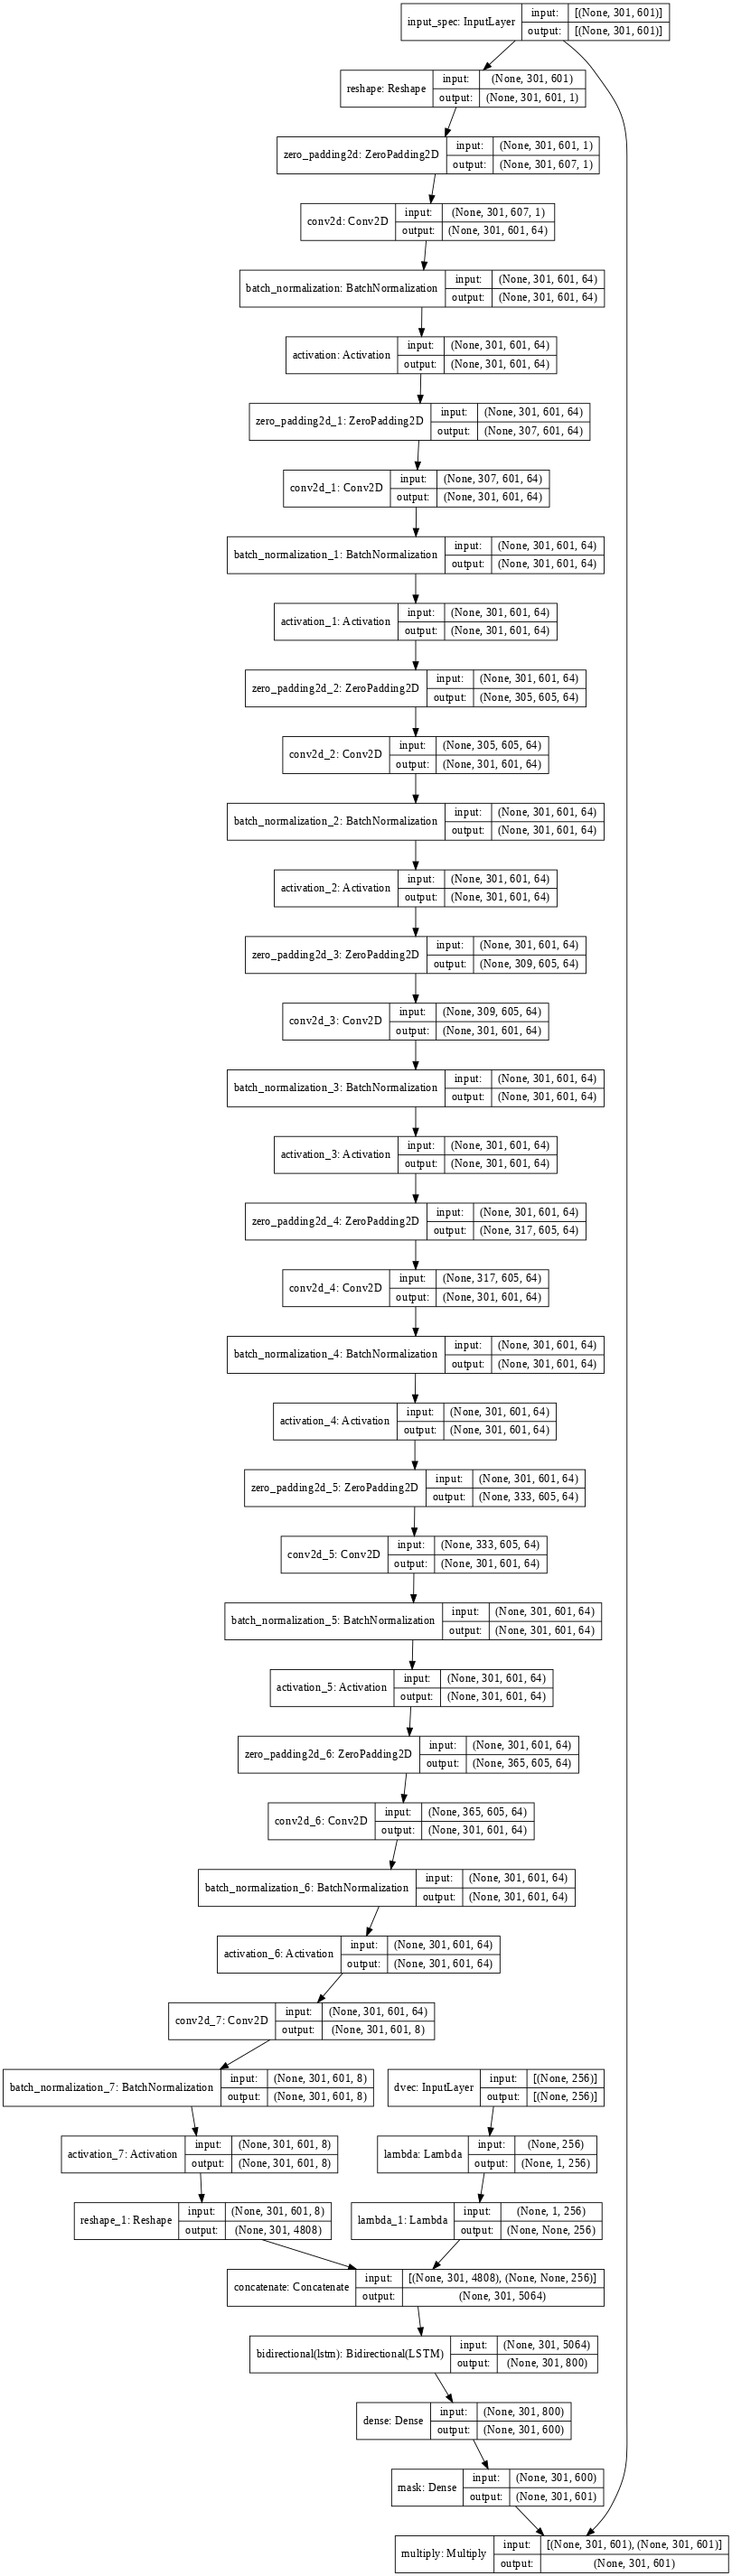

In [ ]:
model.compile(optimizer='adam', loss='mse')
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

### Load Data and Train


In [ ]:
!pip install mir_eval

In [ ]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.utils import Sequence

In [ ]:
# loads the numpy arrays whose path is stored in the column "col" of "data_frame"
def load_col_data(data_frame ,indices, start_pos, end_pos, col):
  col_list = []
  for i in range(start_pos,end_pos):
    idx = indices[i]
    col_list.append(np.load(data_frame[col][idx]))
    # print(idx)
  return np.array(col_list)

In [ ]:
# ## preload training data into 8 separate folders to avoid issues with gdrive
# def preload_training_data(cur_fraction, start_pos, end_pos):
#   input_spec = load_col_data(df_train, list(range(num_samples)) , start_pos , end_pos ,'input_spec_path' )
#   np.save(os.path.join(dataset_path,'PreLoad Training Dataset','fraction_'+str(cur_fraction),'input_spec'),input_spec)
#   output_spec = load_col_data(df_train, list(range(num_samples)), start_pos, end_pos, 'output_spec_path')
#   np.save(os.path.join(dataset_path,'PreLoad Training Dataset','fraction_'+str(cur_fraction),'output_spec'), output_spec)
#   dvec = load_col_data(df_train, list(range(num_samples)), start_pos, end_pos, 'dvec_path')
#   np.save(os.path.join(dataset_path,'PreLoad Training Dataset','fraction_'+str(cur_fraction),'dvec'),dvec)

In [ ]:
# dataset_train = 'train'
# df_train = pd.read_csv(os.path.join(path[dataset_train],'data_frame.csv'))
# num_samples = df_train.shape[0]

In [ ]:
# ## takes approx _ mins
# ### execute just once ###
# # preload training data
# !mkdir 'LibriSpeech Dataset/PreLoad Training Dataset/'
# !mkdir 'LibriSpeech Dataset/PreLoad Training Dataset/fraction_0/'
# !mkdir 'LibriSpeech Dataset/PreLoad Training Dataset/fraction_1/'
# !mkdir 'LibriSpeech Dataset/PreLoad Training Dataset/fraction_2/'
# !mkdir 'LibriSpeech Dataset/PreLoad Training Dataset/fraction_3/'
# !mkdir 'LibriSpeech Dataset/PreLoad Training Dataset/fraction_4/'
# !mkdir 'LibriSpeech Dataset/PreLoad Training Dataset/fraction_5/'
# !mkdir 'LibriSpeech Dataset/PreLoad Training Dataset/fraction_6/'
# !mkdir 'LibriSpeech Dataset/PreLoad Training Dataset/fraction_7/'
# for cur_fraction in range(num_fractions):
#   start_pos = 0
#   for i in range(cur_fraction):
#     start_pos+=fraction_sizes[i]
#   end_pos = start_pos + fraction_sizes[cur_fraction]
#   preload_training_data(cur_fraction, start_pos, end_pos)
#   start_pos, end_pos
#   print(cur_fraction,'/',num_fractions)

In [ ]:
# steps_per_epoch = 0
# for i in range(num_fractions):
#   steps_per_epoch += (fraction_sizes[i]+batch_size-1)//batch_size
# print(steps_per_epoch)

In [ ]:
from tensorflow.keras.utils import Sequence

In [ ]:
class data_generator(Sequence):
  def __init__(self, fraction_sizes , batch_size):
    self.batch_size = batch_size
    self.fraction_sizes = fraction_sizes
    self.num_fractions = len(fraction_sizes)
    self.num_samples = sum(self.fraction_sizes)
    self.pos = 0
    self.cur_fraction = 0
    self.input_spec=None
    self.output_spec=None
    self.dvec=None
  def __len__(self):
    self.num_batches = 0
    for i in range(self.num_fractions):
      self.num_batches += (self.fraction_sizes[i]+self.batch_size-1)//self.batch_size
    #print("len ",self.num_batches)
    return self.num_batches
  def __getitem__(self,batch_index):
    if batch_index == 0:
      self.pos = 0
    start_pos = self.pos
    end_pos = start_pos + self.batch_size
    if end_pos > self.fraction_sizes[self.cur_fraction]:
      end_pos = self.fraction_sizes[self.cur_fraction]
    if start_pos == 0 :
      print("Loading new data")
      if self.input_spec is not None:
        print("de-allocating memory space of old data")
        del self.input_spec
        del self.output_spec
        del self.dvec
        print("de-allocation complete")
      indices = np.random.permutation(self.fraction_sizes[self.cur_fraction])
      self.input_spec = np.load(os.path.join(dataset_path,'PreLoad Training Dataset','fraction_'+str(self.cur_fraction),'input_spec.npy'))[indices]
      self.output_spec = np.load(os.path.join(dataset_path,'PreLoad Training Dataset','fraction_'+str(self.cur_fraction),'output_spec.npy'))[indices]
      self.dvec = np.load(os.path.join(dataset_path,'PreLoad Training Dataset','fraction_'+str(self.cur_fraction),'dvec.npy'))[indices]
      del indices
      print("New data loaded")
    if end_pos == self.fraction_sizes[self.cur_fraction]:
      self.cur_fraction += 1
      if self.cur_fraction == self.num_fractions:
        self.cur_fraction = 0
      self.pos = 0
    else :
      self.pos = end_pos
    input_spec_batch = np.copy(self.input_spec[start_pos:end_pos])  # creating a copy so that input_spec, output_spec, dvec can be deleted when loading subsequent batches
    dvec_batch = np.copy(self.dvec[start_pos:end_pos])
    output_spec_batch = np.copy(self.output_spec[start_pos:end_pos])
    return ({'input_spec':input_spec_batch, 'dvec': dvec_batch}, output_spec_batch)
  def on_epoch_end(self):
    self.pos = 0
    self.cur_fraction = 0

In [ ]:
# gen_train = data_generator(fraction_sizes, batch_size)

In [ ]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm.notebook import tqdm

In [ ]:
# model_checkpoint_callback = ModelCheckpoint(
#     os.path.join('drive/MyDrive/LibriSpeech Dataset/Model weights','weights_epoch{epoch:04d}.h5'),save_weights_only=True)

In [ ]:
# ### config ###
# initial_epoch = 30
# epochs = 40
# batch_size = 8

In [ ]:
### execute just once ###
# !mkdir "drive/MyDrive/LibriSpeech Dataset/Model weights/"
# model.save_weights(os.path.join('drive/MyDrive/LibriSpeech Dataset/Model weights','weights_epoch0000.h5'))

In [ ]:
# model.load_weights(os.path.join('drive/MyDrive/LibriSpeech Dataset/Model weights','weights_epoch0030.h5'))

In [ ]:
# hist = model.fit(gen_train, epochs=epochs, verbose=1, steps_per_epoch = steps_per_epoch, shuffle=False,
#                  initial_epoch = initial_epoch,
#           callbacks=[ model_checkpoint_callback ] )

In [ ]:
# loss = hist.history['loss']
# # !mkdir "drive/MyDrive/LibriSpeech Dataset/Training Loss/"
# np.save(os.path.join('drive/MyDrive/LibriSpeech Dataset/Training Loss/training_loss_total_epochs%04d'%epochs),np.array(loss))

### Visualize model training

In [ ]:
!pip install mir_eval

In [ ]:
import pandas as pd
import numpy as np
from mir_eval.separation import bss_eval_sources
from tqdm import tqdm

In [ ]:
def load_col_data(data_frame ,indices, start_pos, end_pos, col):
  col_list = []
  for i in range(start_pos,end_pos):
    idx = indices[i]
    col_list.append(np.load(data_frame[col][idx]))
    # print(idx)
  return np.array(col_list)

In [ ]:
dataset = 'dev'

In [ ]:
### To be executed just once ###
# preload all data into disk
df = pd.read_csv(os.path.join(path[dataset],'data_frame.csv'))
output_spec = load_col_data(df, list(range(df.shape[0])), 0 , df.shape[0] ,'output_spec_path')
output_phase = load_col_data(df,list(range(df.shape[0])), 0 , df.shape[0] ,'output_phase_path')
input_spec = load_col_data(df, list(range(df.shape[0])), 0 , df.shape[0] ,'input_spec_path')
input_phase = load_col_data(df,list(range(df.shape[0])), 0 , df.shape[0] ,'input_phase_path')
dvec = load_col_data(df,list(range(df.shape[0])), 0 , df.shape[0] ,'dvec_path')
np.save(os.path.join(path[dataset],'output_spec.npy'),output_spec)
np.save(os.path.join(path[dataset],'output_phase.npy'),output_phase)
np.save(os.path.join(path[dataset],'input_spec.npy'),input_spec)
np.save(os.path.join(path[dataset],'input_phase.npy'),input_phase)
np.save(os.path.join(path[dataset],'dvec.npy'),dvec)

In [ ]:
# load the dev dataset
input_spec = np.load(os.path.join(path[dataset],'input_spec.npy'))
input_phase = np.load(os.path.join(path[dataset],'input_phase.npy'))
output_spec = np.load(os.path.join(path[dataset],'output_spec.npy'))
output_phase = np.load(os.path.join(path[dataset],'output_phase.npy'))
dvec = np.load(os.path.join(path[dataset],'dvec.npy'))

In [ ]:
# re construct target waves using output spectrogram and output phase
target_waves = []
for i in tqdm(range(output_spec.shape[0])):
  target_waves.append(audio.spec2wave(output_spec[i], output_phase[i]))
val_loss = []
val_sdr = []

100%|██████████| 920/920 [00:14<00:00, 64.88it/s]


In [ ]:
def compute_loss_sdr(weights_path):
  model.load_weights(weights_path)
  predict_spec = model.predict(x={'input_spec':input_spec,'dvec':dvec} , batch_size = batch_size, verbose = 1)
  val_loss.append(np.mean(np.square(output_spec - predict_spec)))
  sdr=[]
  for i in tqdm(range(predict_spec.shape[0])):
    predict_wave = audio.spec2wave(predict_spec[i], input_phase[i])
    sdr.append(bss_eval_sources(target_waves[i], predict_wave, False)[0][0])
  val_sdr.append(np.median(np.array(sdr)))

In [ ]:
### config ###
start_epochs = 36
end_epochs = 41

In [ ]:
for i in range(start_epochs,end_epochs):
  weights_path = os.path.join('drive/MyDrive/LibriSpeech Dataset/Model weights','weights_epoch%04d.h5'%i)
  compute_loss_sdr(weights_path)
  print()
  print(i,'/',end_epochs,val_loss,val_sdr)

print()
print(val_loss)
print(val_sdr)
np.save(os.path.join('drive/MyDrive/LibriSpeech Dataset/Dev Loss/new_val_loss_total_epochs%04d'%(end_epochs-1)),np.array(val_loss))
np.save(os.path.join('drive/MyDrive/LibriSpeech Dataset/Dev Loss/new_val_sdr_total_epochs%04d'%(end_epochs-1)),np.array(val_sdr))

119/119 [==============================] - 51s 432ms/step


100%|██████████| 949/949 [01:18<00:00, 12.01it/s]



36 / 41 [0.011975689, 0.011710536, 0.011847495, 0.011702371, 0.011590742, 0.011410577] [3.949655658379112, 4.272672776595395, 4.2057091706967205, 4.190498620088226, 4.350198790739217, 4.192645633348572]
119/119 [==============================] - 52s 433ms/step


100%|██████████| 949/949 [01:19<00:00, 11.91it/s]



37 / 41 [0.011975689, 0.011710536, 0.011847495, 0.011702371, 0.011590742, 0.011410577, 0.011122807] [3.949655658379112, 4.272672776595395, 4.2057091706967205, 4.190498620088226, 4.350198790739217, 4.192645633348572, 4.6159559953323]
119/119 [==============================] - 52s 433ms/step


100%|██████████| 949/949 [01:20<00:00, 11.83it/s]



38 / 41 [0.011975689, 0.011710536, 0.011847495, 0.011702371, 0.011590742, 0.011410577, 0.011122807, 0.011440621] [3.949655658379112, 4.272672776595395, 4.2057091706967205, 4.190498620088226, 4.350198790739217, 4.192645633348572, 4.6159559953323, 4.498563754527481]
119/119 [==============================] - 52s 434ms/step


100%|██████████| 949/949 [01:22<00:00, 11.55it/s]



39 / 41 [0.011975689, 0.011710536, 0.011847495, 0.011702371, 0.011590742, 0.011410577, 0.011122807, 0.011440621, 0.011295186] [3.949655658379112, 4.272672776595395, 4.2057091706967205, 4.190498620088226, 4.350198790739217, 4.192645633348572, 4.6159559953323, 4.498563754527481, 4.680421256070702]
119/119 [==============================] - 52s 433ms/step


100%|██████████| 949/949 [01:21<00:00, 11.58it/s]


40 / 41 [0.011975689, 0.011710536, 0.011847495, 0.011702371, 0.011590742, 0.011410577, 0.011122807, 0.011440621, 0.011295186, 0.011300435] [3.949655658379112, 4.272672776595395, 4.2057091706967205, 4.190498620088226, 4.350198790739217, 4.192645633348572, 4.6159559953323, 4.498563754527481, 4.680421256070702, 4.671807367591583]

[0.011975689, 0.011710536, 0.011847495, 0.011702371, 0.011590742, 0.011410577, 0.011122807, 0.011440621, 0.011295186, 0.011300435]
[3.949655658379112, 4.272672776595395, 4.2057091706967205, 4.190498620088226, 4.350198790739217, 4.192645633348572, 4.6159559953323, 4.498563754527481, 4.680421256070702, 4.671807367591583]


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# ## copied
# # load the dev dataset
# input_spec = np.load(os.path.join(path[dataset],'input_spec.npy'))
# input_phase = np.load(os.path.join(path[dataset],'input_phase.npy'))
# output_spec = np.load(os.path.join(path[dataset],'output_spec.npy'))
# output_phase = np.load(os.path.join(path[dataset],'output_phase.npy'))
# dvec = np.load(os.path.join(path[dataset],'dvec.npy'))

# # re construct target waves using output spectrogram and output phase
# target_waves = []
# for i in tqdm(range(output_spec.shape[0])):
#   target_waves.append(audio.spec2wave(output_spec[i], output_phase[i]))
# val_loss = []
# val_sdr = []

# def compute_loss_sdr(weights_path):
#   model.load_weights(weights_path)
#   predict_spec = model.predict(x={'input_spec':input_spec,'dvec':dvec} , batch_size = batch_size, verbose = 1)
#   val_loss.append(np.mean(np.square(output_spec - predict_spec)))
#   sdr=[]
#   for i in tqdm(range(predict_spec.shape[0])):
#     predict_wave = audio.spec2wave(predict_spec[i], input_phase[i])
#     sdr.append(bss_eval_sources(target_waves[i], predict_wave, False)[0][0])
#   val_sdr.append(np.median(np.array(sdr)))

# ### config ###
# start_epochs = 20
# end_epochs = 21

# for i in range(start_epochs,end_epochs):
#   weights_path = os.path.join('drive/MyDrive/LibriSpeech Dataset/Model weights','weights_epoch%04d.h5'%i)
#   compute_loss_sdr(weights_path)
# print()
# print(val_loss)
# print(val_sdr)
# np.save(os.path.join('drive/MyDrive/LibriSpeech Dataset/Dev Loss/val_loss_total_epochs%04d'%(end_epochs-1)),np.array(val_loss))
# np.save(os.path.join('drive/MyDrive/LibriSpeech Dataset/Dev Loss/val_sdr_total_epochs%04d'%(end_epochs-1)),np.array(val_sdr))

# import matplotlib.pyplot as plt
# %matplotlib inline

In [ ]:
# loss = np.load(os.path.join('drive/MyDrive/LibriSpeech Dataset/Training Loss/training_loss_total_epochs%04d.npy'%(end_epochs-1)))

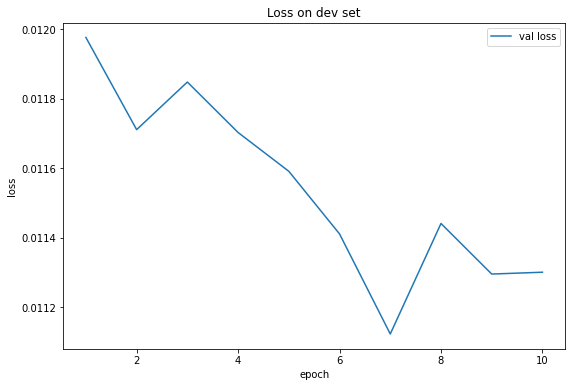

In [ ]:
# plot loss on train and dev set
fig , axis = plt.subplots(1,1,figsize = (9,6))
# axis.plot(np.array(range(1,len(loss)+1)),loss,label="training loss")
axis.plot(np.array(range(1,len(val_loss)+1)),val_loss,label="val loss")
axis.legend()
#plt.xticks(np.array(range(len(loss)+1)))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss on dev set')
plt.show()
fig.savefig('loss.png')

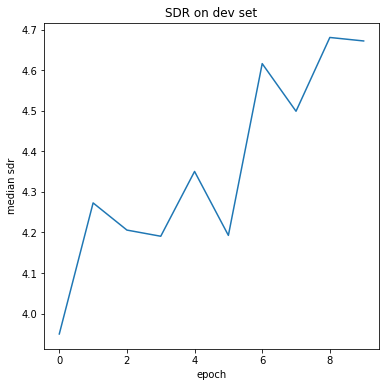

In [ ]:
# plot sdr on dev set
fig , axis = plt.subplots(1,1,figsize = (6,6))
axis.plot(np.array(range(len(val_sdr))), val_sdr, label = "median sdr on val set")
plt.xlabel('epoch')
plt.ylabel('median sdr')
plt.title('SDR on dev set')
plt.show()
fig.savefig('sdr.png')

### Test set metrics

In [ ]:
dataset = 'test'

In [ ]:
### To be executed just once ###
# preload all data into disk
df = pd.read_csv(os.path.join(path[dataset],'data_frame.csv'))
output_spec = load_col_data(df, list(range(df.shape[0])), 0 , df.shape[0] ,'output_spec_path')
output_phase = load_col_data(df,list(range(df.shape[0])), 0 , df.shape[0] ,'output_phase_path')
input_spec = load_col_data(df, list(range(df.shape[0])), 0 , df.shape[0] ,'input_spec_path')
input_phase = load_col_data(df,list(range(df.shape[0])), 0 , df.shape[0] ,'input_phase_path')
dvec = load_col_data(df,list(range(df.shape[0])), 0 , df.shape[0] ,'dvec_path')
np.save(os.path.join(path[dataset],'output_spec.npy'),output_spec)
np.save(os.path.join(path[dataset],'output_phase.npy'),output_phase)
np.save(os.path.join(path[dataset],'input_spec.npy'),input_spec)
np.save(os.path.join(path[dataset],'input_phase.npy'),input_phase)
np.save(os.path.join(path[dataset],'dvec.npy'),dvec)

In [ ]:
# load the entire dataset
input_spec = np.load(os.path.join(path[dataset],'input_spec.npy'))
input_phase = np.load(os.path.join(path[dataset],'input_phase.npy'))
output_spec = np.load(os.path.join(path[dataset],'output_spec.npy'))
output_phase = np.load(os.path.join(path[dataset],'output_phase.npy'))
dvec = np.load(os.path.join(path[dataset],'dvec.npy'))

In [ ]:
# re construct target waves using output spectrogram and output phase
target_waves = []
for i in tqdm(range(output_spec.shape[0])):
  target_waves.append(audio.spec2wave(output_spec[i], output_phase[i]))

100%|██████████| 949/949 [00:14<00:00, 65.54it/s]


In [ ]:
def compute_loss_sdr_test(weights_path):
  model.load_weights(weights_path)
  predict_spec = model.predict(x={'input_spec':input_spec,'dvec':dvec} , batch_size = batch_size, verbose = 1)
  test_loss = np.mean(np.square(output_spec - predict_spec))
  sdr=[]
  for i in tqdm(range(predict_spec.shape[0])):
    predict_wave = audio.spec2wave(predict_spec[i], input_phase[i])
    sdr.append(bss_eval_sources(target_waves[i], predict_wave, False)[0][0])
  test_sdr = np.median(np.array(sdr))
  return test_loss, test_sdr

In [ ]:
weights_path = os.path.join('drive/MyDrive/LibriSpeech Dataset/Model weights','weights_epoch0039.h5')
print("")
print("loss, sdr : ",end="")
print(compute_loss_sdr_test(weights_path))


119/119 [==============================] - 50s 418ms/step


100%|██████████| 949/949 [02:33<00:00,  6.17it/s]

(0.011295186, 4.680421256070702)


### Test audio samples

In [ ]:
## preprocess audio in the same way as training audio input
def preprocess_audio(audio_path):
  wave,_ = librosa.load(audio_path,sr=hyper_params.sample_rate) 
  wave,_ = librosa.effects.trim(wave, top_db=20)  #trim silent portions
  length_wave = int(hyper_params.sample_rate * hyper_params.data_audio_len) 
  if(wave.shape[0]<length_wave) :
    return
  wave = wave[:length_wave] #clip wave to a fixed wavelength
  norm = np.max(np.abs(wave)) * 1.1 #normalize
  wave = wave/norm
  return wave

In [ ]:
## pass input spec and dvec thru model and re construct wave after combining with input phase
def get_filtered_wave(input_spec_path, phase_path, dvec_path):
  input_spec = np.load(input_spec_path)
  phase = np.load(phase_path)
  dvec = np.load(dvec_path)
  dvec = np.expand_dims(dvec,axis=0)
  input_spec = np.expand_dims(input_spec,axis=0)
  clean_spec = model.predict(x={ 'input_spec' : input_spec, 'dvec' : dvec}, verbose=1)
  wave = audio.spec2wave(clean_spec[0],phase)
  return np.asarray(wave)

In [ ]:
from IPython.display import Audio as ipythonAudio
import pandas as pd
import numpy as np
import librosa
import random

In [ ]:
## pass input spec and dvec thru model and re construct wave after combining with input phase
def get_filtered_wave(input_spec, phase, dvec):
  dvec = np.expand_dims(dvec,axis=0)
  input_spec = np.expand_dims(input_spec,axis=0)
  clean_spec = model.predict(x={ 'input_spec' : input_spec, 'dvec' : dvec}, verbose=1)
  wave = audio.spec2wave(clean_spec[0],phase)
  return np.asarray(wave)


hyper_params = HyperParams()
audio = Audio(hyper_params)

ref_wave, _ = librosa.load("drive/MyDrive/LibriSpeech Dataset/sample_audios/1_ref.flac",sr=hyper_params.sample_rate) #load the audio file
pri_wave, _ = librosa.load("drive/MyDrive/LibriSpeech Dataset/sample_audios/1_pri.flac", sr = hyper_params.sample_rate)
sec_wave,_ = librosa.load("drive/MyDrive/LibriSpeech Dataset/sample_audios/1_sec.flac", sr = hyper_params.sample_rate)

length_wave = int(hyper_params.sample_rate * hyper_params.data_audio_len)
pri_wave, sec_wave = pri_wave[:length_wave], sec_wave[:length_wave] # clip wave to fixed length
mix_wave = pri_wave + sec_wave
norm = np.max(np.abs(mix_wave)) * 1.1
pri_wave, mix_wave = pri_wave/norm , mix_wave/norm  # normalize wave by 1.1*max(absolute amplitude)
pri_spec, pri_phase = audio.wave2spec(pri_wave)  # convert wave to spec
mix_spec, mix_phase = audio.wave2spec(mix_wave)

dvec = get_dvector(ref_wave)

#workflow to test model on random audio speech

# ref_wave = preprocess_audio("drive/MyDrive/LibriSpeech Dataset/Sample Audios/1_ref.wav")
# ref_wave,_ = librosa.load("drive/MyDrive/LibriSpeech Dataset/Sample Audios/8_ref.wav", sr=hyper_params.sample_rate)
# ref_wave,_ = librosa.effects.trim(ref_wave, top_db = 20)
# print(type(ref_wave))

# dvec = get_dvector(ref_wave)
# ipythonAudio(ref_wave, rate = hyper_params.sample_rate)

In [ ]:
# ref wave
ipythonAudio(ref_wave, rate = hyper_params.sample_rate)

In [ ]:
# pri wave
ipythonAudio(pri_wave, rate = hyper_params.sample_rate)

In [ ]:
# sec wave
ipythonAudio(sec_wave, rate = hyper_params.sample_rate)

In [ ]:
# mix wave
ipythonAudio(mix_wave, rate = hyper_params.sample_rate)

In [ ]:
# filtered wave after 0 epochs
model.load_weights(os.path.join('drive/MyDrive/LibriSpeech Dataset/Model weights','weights_epoch0000.h5'))
filtered_wave = get_filtered_wave(mix_spec, mix_phase, dvec)
ipythonAudio(filtered_wave, rate = hyper_params.sample_rate)

1/1 [==============================] - 0s 128ms/step


In [ ]:
# filtered wave after 40 epochs
model.load_weights(os.path.join('drive/MyDrive/LibriSpeech Dataset/Model weights','weights_epoch0040.h5'))
filtered_wave = get_filtered_wave(mix_spec, mix_phase, dvec)
ipythonAudio(filtered_wave, rate = hyper_params.sample_rate)

1/1 [==============================] - 0s 104ms/step


In [ ]:
## pass input spec and dvec thru model and re construct wave after combining with input phase
def get_filtered_wave(input_spec, phase, dvec):
  dvec = np.expand_dims(dvec,axis=0)
  input_spec = np.expand_dims(input_spec,axis=0)
  clean_spec = model.predict(x={ 'input_spec' : input_spec, 'dvec' : dvec}, verbose=1)
  wave = audio.spec2wave(clean_spec[0],phase)
  return np.asarray(wave)


hyper_params = HyperParams()
audio = Audio(hyper_params)

ref_wave, _ = librosa.load("drive/MyDrive/LibriSpeech Dataset/sample_audios/5_ref.flac",sr=hyper_params.sample_rate) #load the audio file
pri_wave, _ = librosa.load("drive/MyDrive/LibriSpeech Dataset/sample_audios/6_pri.flac", sr = hyper_params.sample_rate)

length_wave = int(hyper_params.sample_rate * hyper_params.data_audio_len)
pri_wave = pri_wave[:length_wave] # clip wave to fixed length
mix_wave = pri_wave
norm = np.max(np.abs(mix_wave)) * 1.1
pri_wave, mix_wave = pri_wave/norm , mix_wave/norm  # normalize wave by 1.1*max(absolute amplitude)
pri_spec, pri_phase = audio.wave2spec(pri_wave)  # convert wave to spec
mix_spec, mix_phase = audio.wave2spec(mix_wave)

dvec = get_dvector(ref_wave)

In [ ]:
# ref wave
ipythonAudio(ref_wave, rate = hyper_params.sample_rate)

In [ ]:
# pri wave
ipythonAudio(pri_wave, rate = hyper_params.sample_rate)

In [ ]:
# mix wave
ipythonAudio(mix_wave, rate = hyper_params.sample_rate)

In [ ]:
# filtered wave after 0 epochs
model.load_weights(os.path.join('drive/MyDrive/LibriSpeech Dataset/Model weights','weights_epoch0000.h5'))
filtered_wave = get_filtered_wave(pri_spec, pri_phase, dvec)
ipythonAudio(filtered_wave, rate = hyper_params.sample_rate)

1/1 [==============================] - 0s 127ms/step


In [ ]:
# filtered wave after 40 epochs
model.load_weights(os.path.join('drive/MyDrive/LibriSpeech Dataset/Model weights','weights_epoch0040.h5'))
filtered_wave = get_filtered_wave(pri_spec, pri_phase, dvec)
ipythonAudio(filtered_wave, rate = hyper_params.sample_rate)

1/1 [==============================] - 0s 129ms/step
